# Linear regression analysis

Import necessary libraries

In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
import missingno as mno
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
import operator
import statsmodels.api as sm
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline
sns.set(style="white")  

## Roadmap of this notebook: 
- EDA: which audience score data is best: RottenTomatoes, Metacritic or IMDb? *Note*: we say that anything normally distributed about a mean of 7 (that is seen as "average") in the movie industry, is OK.
- Use IMDb data
- Drop NA IMDb values (n=~300)
- Drop NA genre values (n=30)
- Train/val/test split
- One-hot-enconding of genre w/ target (IMDb rating) 
- Baseline linear regression: Training data R^2 = 0.09
- Add in genre/genre interactions: Training data R^2 = 0.18
- Add in one-hot-encoded distributor: Training data R^2 = 0.27
  

In [2]:
mojo = pd.read_csv('data/mojo.csv')
imdb = pd.read_csv('data/imdb.csv')
metacritic = pd.read_csv('data/metacritic.csv')
tomato = pd.read_csv('data/rotten_tomatoes.csv')
heirloom = pd.read_csv('data/heirloom.csv')
mojo.rename(columns={"title": "mojo_title"}, inplace=True)
heirloom.set_index(['mojo_title'])
imdb.set_index(['mojo_title'])
metacritic.set_index(['mojo_title'])
tomato.set_index(['mojo_title'])
mojo.set_index(['mojo_title'])

mojo.head(1)

,mojo_title,domestic_revenue,international_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Made in France,"$9,956",NaN,"$9,956",Under The Milky Way,"$3,688",2 theaters,NaN,NaN,"Crime, Drama, Thriller","Sep 23, 2016"


# EDA of RottenTomatoes

In [3]:
tomato_final = tomato.merge(heirloom, on='mojo_title', how='left')

In [4]:
tomato_final = tomato_final.drop(['url_y', 'tomato_criticcount_x'], axis=1)

In [5]:
tomato_final = tomato_final.rename(columns={"tomato_criticcount_y":"tomato_criticcount", "url_x":"url"})

In [6]:
tomato_final = tomato_final.dropna(subset=['tomato_image'])

In [7]:
def get_img_url(df):  
    return re.findall('(?<=data-src).*$', df)[0][2:-2]
tomato_final['tomato_image'] = tomato_final['tomato_image'].apply(get_img_url)

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

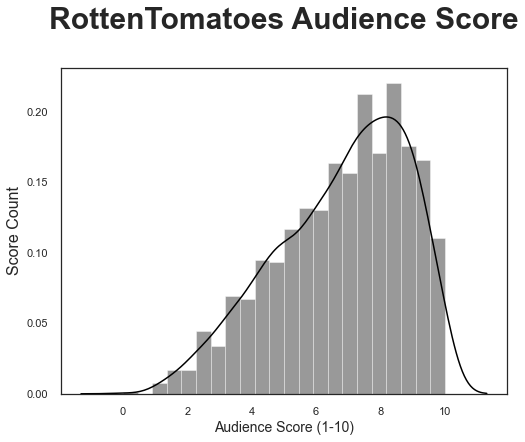

In [8]:
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.distplot(tomato_final['tomato_audiencescore']/10, color="black")
ax.set_title("RottenTomatoes Audience Score", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Audience Score (1-10)', fontsize=14)
plt.ylabel('Score Count', fontsize=16)
plt.plot()

## Rotten tomatoes is non-normal and is skewed for audience score.

## Let's check IMDb

In [9]:
imdb['imdbscore'].isna().sum()

1

In [10]:
imdb = imdb.drop(imdb[imdb['imdbscore']=='Link error'].index)

In [11]:
imdb['imdbscore'] = pd.to_numeric(imdb['imdbscore'])

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

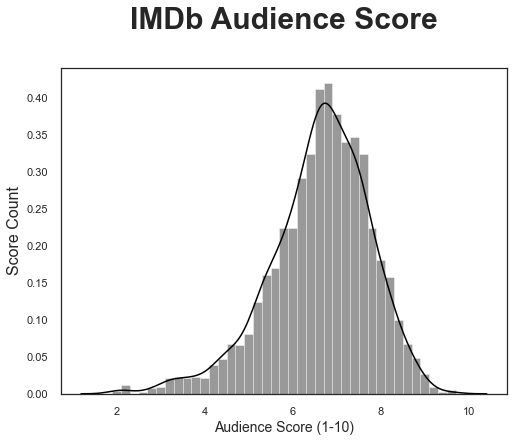

In [12]:
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.distplot(imdb['imdbscore'], color="black")
ax.set_title("IMDb Audience Score", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Audience Score (1-10)', fontsize=14)
plt.ylabel('Score Count', fontsize=16)
plt.plot()

### IMDb is normal, we can use IMDb

## Let's check Metacritic

In [13]:
metacritic.isna().sum()

mojo_title            0
mc_criticscore        1
mc_criticcount        1
mc_audiencescore      1
mc_audiencecount    383
dtype: int64

In [14]:
drop = ['tbd', 'Link error']
metacritic.drop(metacritic.index[metacritic['mc_criticscore'].isin(drop)], inplace = True)

In [15]:
metacritic['mc_criticscore'] = pd.to_numeric(metacritic['mc_criticscore'])

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

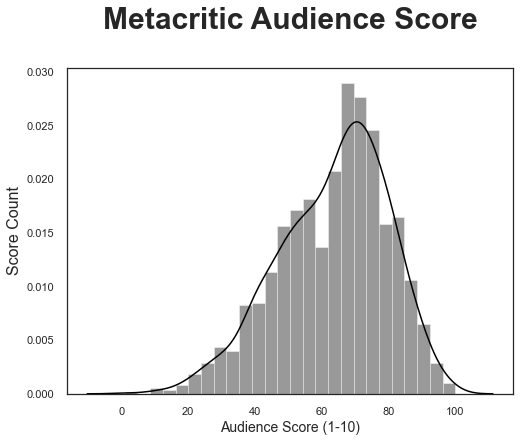

In [16]:
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.distplot(metacritic['mc_criticscore'], color="black")
ax.set_title("Metacritic Audience Score", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Audience Score (1-10)', fontsize=14)
plt.ylabel('Score Count', fontsize=16)
plt.plot()

### Metacritic is also fairly normal.

In [17]:
# This is for overlaying the three graphs, which seems un-necessary
# sns.set(font_scale = 2)

# sns.set_style(style='white') 
# fig, ax = plt.subplots(figsize=(15,10))
# sns.distplot( df["imdbscore"] , color="skyblue", label="IMDB's score",hist=None)
# sns.distplot( df["mc_audiencescore"]/10 , color="green", label="RottenTomatoe's audience score",hist=None)

# sns.distplot( df["tomato_audiencescore"]/10 , color="red", label="RottenTomatoe's audience score", hist=None)
# fig.legend(labels=['IMDB','Metacritic', 'RottenTomatoes'])
# ax.set_title("Review Distributions", fontsize=30, weight='bold', y=1.1)
# ax.set(xlabel="Audience Rating (scaled to 1-10)",
#        ylabel="KDE Estimate", xlim=(0, 10))
# sns.despine()

## Since Metacritic and IMDb are both normally distributed about a mean of 7, we will go with IMDb, as we have more IDMb data.

In [18]:
df = mojo.merge(imdb, on='mojo_title', how='left')

#This does not return 3107 rows, it returns 3369. I checked below that these duplicates are in fact the exact same
#across columns and that no information loss occurs.
#
#As a result, it is OK by me to just drop these duplicates.


## Null values

Missing values visualization (white = missing)

<AxesSubplot:>

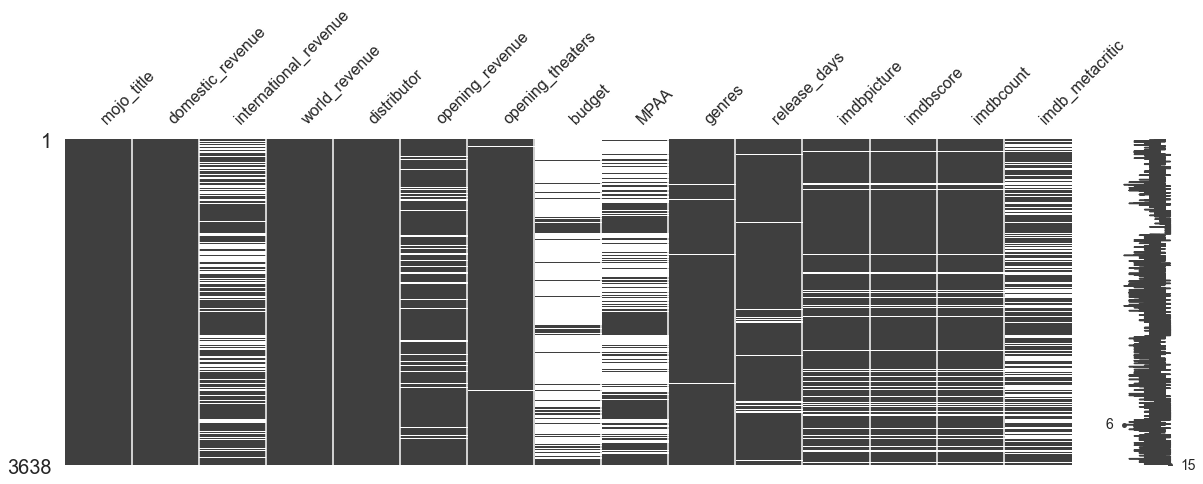

In [19]:
mno.matrix(df, figsize = (20, 6))


*Note*: this is probably because for IMDb we did not use a rigorous search algorithm to find each movie, we just guessed the url. The errors are independent and random, non-centarlized by movie, but that is why we see them at all.

We remove Budget, MPAA rating (too little data), and discard imdbpicture, imdbcount, and imdb_metacritic (irrelevant to our analysis). We will impute international revenue, imdbscore. 

In [20]:
df.drop(columns=['budget', 'MPAA', 'imdbpicture', 'imdbcount', 'imdb_metacritic', 'release_days', 'opening_theaters'], inplace=True)

<AxesSubplot:>

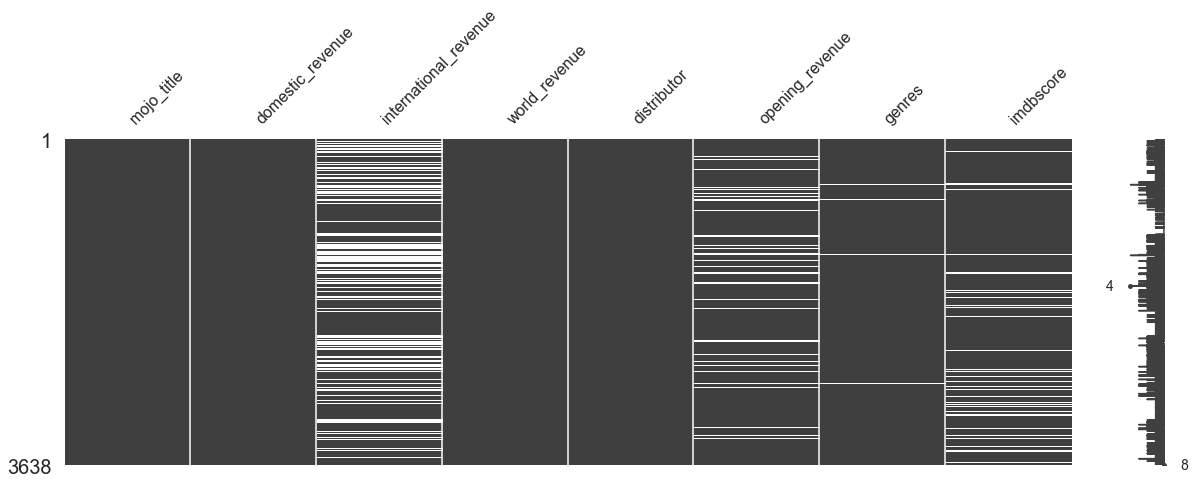

In [21]:
mno.matrix(df, figsize = (20, 6))


We cannot afford to impute any imdbscore, so we will drop NA from this column.

In [22]:
df = df.dropna(subset=['imdbscore'])

<AxesSubplot:>

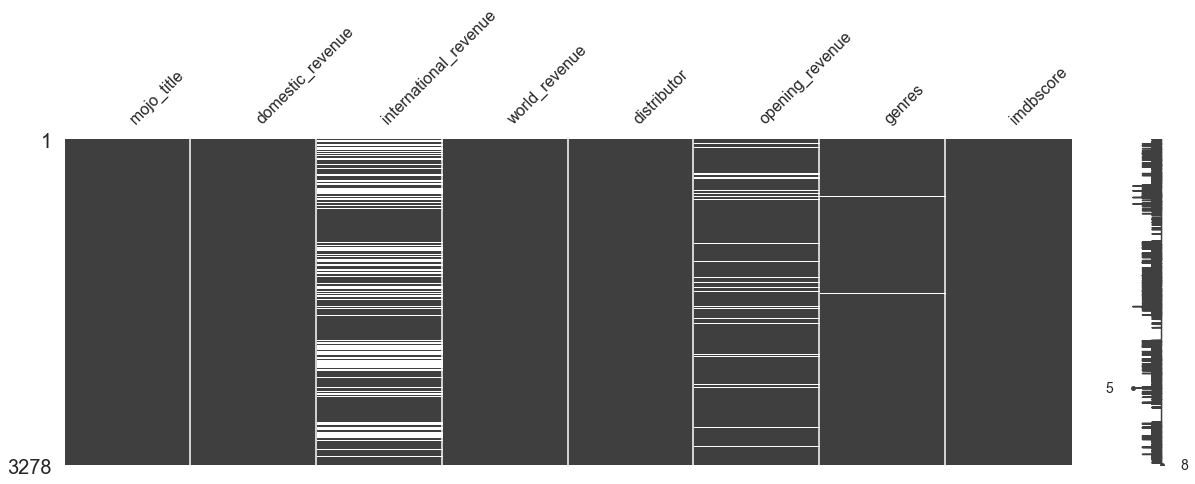

In [23]:
mno.matrix(df, figsize = (20, 6))


In [24]:
# turn $2,000 into 2000

# money = ['domestic_revenue', 'international_reveneue', 'world_revenue', 'opening_revenue']
# for i in range(0, len(money)):
#     df[money[i]] = df[money[i]].replace(',', '')
#     df[money[i]] = df[money[i]].replace('$', '')
#     df[money[i]] = pd.to_numeric(df[money[i]])

df['domestic_revenue'] = df['domestic_revenue'].str.replace(',', '')
df['domestic_revenue'] = df['domestic_revenue'].str.replace('$', '')
df['domestic_revenue'] = pd.to_numeric(df['domestic_revenue'])
df['international_revenue'] = df['international_revenue'].str.replace(',', '')
df['international_revenue'] = df['international_revenue'].str.replace('$', '')
df['international_revenue'] = pd.to_numeric(df['international_revenue'])
df['world_revenue'] = df['world_revenue'].str.replace(',', '')
df['world_revenue'] = df['world_revenue'].str.replace('$', '')
df['world_revenue'] = pd.to_numeric(df['world_revenue'])
df['opening_revenue'] = df['opening_revenue'].str.replace(',', '')
df['opening_revenue'] = df['opening_revenue'].str.replace('$', '')
df['opening_revenue'] = pd.to_numeric(df['opening_revenue'])

In [25]:
df

,mojo_title,domestic_revenue,international_revenue,world_revenue,distributor,opening_revenue,genres,imdbscore
0,Made in France,9956,NaN,9956,Under The Milky Way,3688.0,"Crime, Drama, Thriller",6.2
1,Realms,147,22296.0,22443,The Film Arcade,108.0,"Horror, Mystery",5.5
2,Postcards from London,5312,10236.0,15548,Strand Releasing,2686.0,Drama,5.1
3,Over the Limit,3243,NaN,3243,Film Movement,1402.0,"Documentary, Sport",7.4
4,Tall Tales from the Magical Garden of Antoon K...,220,14340506.0,14340726,Viva Pictures,NaN,"Adventure, Animation, Comedy, Family",4.6
...,...,...,...,...,...,...,...,...
3632,Star Wars: Episode IX - The Rise of Skywalker,515202542,558941706.0,1074144248,Walt Disney Studios Motion Pictures,177383864.0,"Action, Adventure, Fantasy, Sci-Fi",6.5
3633,Jumanji: The Next Level,320314960,479744747.0,800059707,Sony Pictures Entertainment (SPE),59251543.0,"Action, Adventure, Comedy, Fantasy",6.7
3635,1917,159227644,225679098.0,384906742,Universal Pictures,576216.0,"Drama, Thriller, War",8.3
3636,1917,159227644,225679098.0,384906742,Universal Pictures,576216.0,"Drama, Thriller, War",7.3


## Create a new df with just IMDB score (called "df_new")


In [26]:
df_new = df
df['domestic_international_ratio'] = df['domestic_revenue'] / df['international_revenue']
df_new = df_new.drop(columns=['mojo_title', 'international_revenue', 'domestic_revenue',
                             'opening_revenue'], axis=1)

#df_new['domestic_international_ratio'] = df['domestic_revenue'] / df['international_reveneue']

#let's drop revenues, as those present the risk of multicolinearity
# df_new = df_new.drop(columns=['domestic_revenue', 'international_reveneue', 'opening_revenue']).head(2)

In [27]:
df_new.head()

,world_revenue,distributor,genres,imdbscore,domestic_international_ratio
0,9956,Under The Milky Way,"Crime, Drama, Thriller",6.2,NaN
1,22443,The Film Arcade,"Horror, Mystery",5.5,0.006593
2,15548,Strand Releasing,Drama,5.1,0.518953
3,3243,Film Movement,"Documentary, Sport",7.4,NaN
4,14340726,Viva Pictures,"Adventure, Animation, Comedy, Family",4.6,0.000015


We will drop the 20 N/A values for genre.

In [28]:
df_new = df_new.dropna(subset=['genres'])

## One-hot-encoding of genre

In [29]:
df_new['imdbscore'].isnull().values.any()

False

In [30]:
df_new['imdbscore']

0       6.2
1       5.5
2       5.1
3       7.4
4       4.6
       ... 
3632    6.5
3633    6.7
3635    8.3
3636    7.3
3637    6.6
Name: imdbscore, Length: 3258, dtype: float64

In [31]:
# df['opening_theaters'] = df['opening_theaters'].str.extract(r'([^\s]+)')
# df['opening_theaters'] = df['opening_theaters'].str.replace(',', '')
# df['opening_theaters'] = pd.to_numeric(df['opening_theaters'])
genres = np.unique(', '.join(df_new['genres']).split(', '))
genres = np.delete(genres, np.where(genres == 'NA'))
for genre in genres:
    df_new[genre] = df_new['genres'].str.contains(genre).astype('int')
df_new.drop('genres', axis=1, inplace=True)

In [32]:
df_new.sample(10)

,world_revenue,distributor,imdbscore,domestic_international_ratio,Action,Adult,Adventure,Animation,Biography,Comedy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
469,18653040,STX Entertainment,3.3,0.007085,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1528,99488,Fathom Events,6.7,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1202,8905,Abramorama,7.7,3.803128,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1396,3322479,FilmRise,7.1,0.011295,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1860,36075317,Swen Releasing,6.7,0.028985,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2814,7478354,Music Box Films,7.5,0.133518,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1092,1227,Indican Pictures,6.7,NaN,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2724,1695119,Warner Bros.,7.8,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1034,491730089,Walt Disney Studios Motion Pictures,6.6,0.301560,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
617,318885,Fathom Events,8.8,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Genre is one-hot-encoded. Train/val/test split to give baseline R^2.

## Baseline linear regression w/ Genre

Validation method: Train / Validation / Test

In [33]:
#hold 20% for final testing
X, y = df_new, df_new['imdbscore']

#train test split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [34]:
#split training into validation and train
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

Target: IMDB score; features: genres; question: do people like one genre over the other?

In [35]:
target = df_new['imdbscore']
features = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
               'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
               'News', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

**Baseline test on training data for linear regression**

In [36]:
pd.to_numeric(X_train.iloc[:, 2].fillna(0))

2280    5.4
313     6.7
1387    7.8
1514    6.5
1341    5.0
       ... 
218     6.8
2562    5.9
582     3.1
987     7.2
1136    6.9
Name: imdbscore, Length: 1954, dtype: float64

In [37]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, 4:])

lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
print(f'Baseline linear regression (TRAINING DATA; ignoring distributor) val R^2: {lm.score(X_train_scaled, y_train):.3f}')

Baseline linear regression (TRAINING DATA; ignoring distributor) val R^2: 0.098


**Feature engineering: add in interaction term between genres**

"Horror Thrillers" do better than Horror movies, we assume. If we interact every genre with every genre, and consider those interactions, our R^2 will inevitably go up.

In [38]:
def create_interactions(df):
    df_int = df.copy()
    for i in range(3, len(df.columns)-1):
        for j in range(i+1, len(df.columns)):
            name = str(df.columns[i]) + ' * ' + str(df.columns[j])
            df_int.loc[:, name] = df[str(df.columns[i+1])] * df[str(df.columns[j])]
    return df_int

In [39]:
X_train_interactions = create_interactions(X_train)

In [40]:
X_train_interactions.drop(columns=['distributor'], axis=1)

,world_revenue,imdbscore,domestic_international_ratio,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Short * Sport,Short * Thriller,Short * War,Short * Western,Sport * Thriller,Sport * War,Sport * Western,Thriller * War,Thriller * Western,War * Western
2280,3981,5.4,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,47269,6.7,5.226979,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,36506,7.8,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,363307,6.5,6.134018,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1341,2195706,5.0,0.011173,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2911800,6.8,0.031161,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2562,62398,5.9,NaN,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
582,260234,3.1,NaN,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,91522094,7.2,0.998610,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X_train_interactions = X_train_interactions.drop(columns=['imdbscore'])

In [42]:
X_train_interactions = X_train_interactions.iloc[:, 3:380]

In [43]:
X_train_interactions.iloc[:, 26:380]

,domestic_international_ratio * Action,domestic_international_ratio * Adult,domestic_international_ratio * Adventure,domestic_international_ratio * Animation,domestic_international_ratio * Biography,domestic_international_ratio * Comedy,domestic_international_ratio * Crime,domestic_international_ratio * Documentary,domestic_international_ratio * Drama,domestic_international_ratio * Family,...,Short * Sport,Short * Thriller,Short * War,Short * Western,Sport * Thriller,Sport * War,Sport * Western,Thriller * War,Thriller * Western,War * Western
2280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
scaler = preprocessing.StandardScaler()
X_train_with_interactions_scaled = scaler.fit_transform(X_train_interactions)
baseline_with_interactions = linear_model.LinearRegression()
baseline_with_interactions.fit(X_train_with_interactions_scaled, y=y_train)
print(f'Linear regression (TRAINING DATA) with genre-genre interaction terms val R^2: {baseline_with_interactions.score(X_train_with_interactions_scaled, y_train):.3f}')

Linear regression (TRAINING DATA) with genre-genre interaction terms val R^2: 0.193


**R^2 was doubled or so by introducing interaction terms. Important to note that this is probably over-fitting to this model, since there are probably just a few that pertain to Short War films for example.**

Since it seems like the right direction, we'll add back in X_train_interactions to X_train.

no domestic_international_ratio means there was no international release, so we can fill those to 0

In [45]:
X_train['domestic_international_ratio'].fillna(value=0, inplace=True)

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Add back-in our interaction terms to X_train

In [46]:
X_train2 = X_train.merge(X_train_interactions.iloc[:, 26:380], how='inner', left_index=True, right_index=True)

In [47]:
#I wanted to use cv to find these interactions but this code fails

# regression = LinearRegression(normalize=True)
# crossvalidation = KFold(n=X.shape[0], n_folds=10, shuffle=True, random_state=1)

# df = pd.DataFrame(X_train.iloc[:, 3:31])
# baseline = np.mean(cross_val_score(regression, X_train, y_train, cv=crossvalidation, scoring='r2',
#  n_jobs=1))
# interactions = list()
# for i in X_train.iloc[:, 5:6]:
#  for j in X_train.iloc[:, 3:4]:
#   if i > j:
#    X_train['interaction'] = X_train[i] * X_train[j]
#    score = np.mean(cross_val_score(regression, X_train, y, scoring='r2',
#     cv=crossvalidation, n_jobs=1))
#    if score > baseline:
#     interactions.append((i, j, round(score,3)))
# print('Baseline R2: %.3f' % baseline)
# print('Top 10 interactions: %s' % sorted(interactions, key=lambda x:x[2],
#  reverse=True)[:10])

### Feature engineering: add-in another feature, distributors

Add-in distributors

In [48]:
distributors = df.distributor.value_counts()
distributors

Fathom Events         268
Warner Bros.          200
Universal Pictures    112
IFC Films             103
Indican Pictures       81
                     ... 
Factory 25              1
Strasson Group          1
Idle Wild Films         1
In the Family           1
TriCoast Worldwide      1
Name: distributor, Length: 264, dtype: int64

In [49]:
other_distributors = list(distributors[distributors <= 40].index)
print("Other distributor, defined as less than 10 movies/year, there were {}".format(len(other_distributors)))


Other distributor, defined as less than 10 movies/year, there were 244


In [50]:
X_train2['distributor'] = X_train2['distributor'].replace(other_distributors, 'Other') #replaces <=10 movies/yr. studio
                                                                                       #with zero


In [51]:
X_train2

,world_revenue,distributor,imdbscore,domestic_international_ratio,Action,Adult,Adventure,Animation,Biography,Comedy,...,Short * Sport,Short * Thriller,Short * War,Short * Western,Sport * Thriller,Sport * War,Sport * Western,Thriller * War,Thriller * Western,War * Western
2280,3981,Other,5.4,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,47269,Other,6.7,5.226979,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,36506,Other,7.8,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,363307,Other,6.5,6.134018,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1341,2195706,Other,5.0,0.011173,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2911800,IFC Films,6.8,0.031161,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2562,62398,Other,5.9,0.000000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
582,260234,Fathom Events,3.1,0.000000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,91522094,Lionsgate,7.2,0.998610,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X_train2.columns

Index(['world_revenue', 'distributor', 'imdbscore',
       'domestic_international_ratio', 'Action', 'Adult', 'Adventure',
       'Animation', 'Biography', 'Comedy',
       ...
       'Short * Sport', 'Short * Thriller', 'Short * War', 'Short * Western',
       'Sport * Thriller', 'Sport * War', 'Sport * Western', 'Thriller * War',
       'Thriller * Western', 'War * Western'],
      dtype='object', length=381)

In [53]:
X_train3 = X_train2.copy()
X_train3 = pd.get_dummies(X_train3, columns=['distributor'], drop_first=True)


In [54]:
X_train3 = X_train3.drop(columns=['imdbscore'])

In [55]:
pd.set_option('display.max_columns', None)
X_train3.head()

,world_revenue,domestic_international_ratio,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,domestic_international_ratio * Action,domestic_international_ratio * Adult,domestic_international_ratio * Adventure,domestic_international_ratio * Animation,domestic_international_ratio * Biography,domestic_international_ratio * Comedy,domestic_international_ratio * Crime,domestic_international_ratio * Documentary,domestic_international_ratio * Drama,domestic_international_ratio * Family,domestic_international_ratio * Fantasy,domestic_international_ratio * Film-Noir,domestic_international_ratio * History,domestic_international_ratio * Horror,domestic_international_ratio * Music,domestic_international_ratio * Musical,domestic_international_ratio * Mystery,domestic_international_ratio * News,domestic_international_ratio * Reality-TV,domestic_international_ratio * Romance,domestic_international_ratio * Sci-Fi,domestic_international_ratio * Short,domestic_international_ratio * Sport,domestic_international_ratio * Thriller,domestic_international_ratio * War,domestic_international_ratio * Western,Action * Adult,Action * Adventure,Action * Animation,Action * Biography,Action * Comedy,Action * Crime,Action * Documentary,Action * Drama,Action * Family,Action * Fantasy,Action * Film-Noir,Action * History,Action * Horror,Action * Music,Action * Musical,Action * Mystery,Action * News,Action * Reality-TV,Action * Romance,Action * Sci-Fi,Action * Short,Action * Sport,Action * Thriller,Action * War,Action * Western,Adult * Adventure,Adult * Animation,Adult * Biography,Adult * Comedy,Adult * Crime,Adult * Documentary,Adult * Drama,Adult * Family,Adult * Fantasy,Adult * Film-Noir,Adult * History,Adult * Horror,Adult * Music,Adult * Musical,Adult * Mystery,Adult * News,Adult * Reality-TV,Adult * Romance,Adult * Sci-Fi,Adult * Short,Adult * Sport,Adult * Thriller,Adult * War,Adult * Western,Adventure * Animation,Adventure * Biography,Adventure * Comedy,Adventure * Crime,Adventure * Documentary,Adventure * Drama,Adventure * Family,Adventure * Fantasy,Adventure * Film-Noir,Adventure * History,Adventure * Horror,Adventure * Music,Adventure * Musical,Adventure * Mystery,Adventure * News,Adventure * Reality-TV,Adventure * Romance,Adventure * Sci-Fi,Adventure * Short,Adventure * Sport,Adventure * Thriller,Adventure * War,Adventure * Western,Animation * Biography,Animation * Comedy,Animation * Crime,Animation * Documentary,Animation * Drama,Animation * Family,Animation * Fantasy,Animation * Film-Noir,Animation * History,Animation * Horror,Animation * Music,Animation * Musical,Animation * Mystery,Animation * News,Animation * Reality-TV,Animation * Romance,Animation * Sci-Fi,Animation * Short,Animation * Sport,Animation * Thriller,Animation * War,Animation * Western,Biography * Comedy,Biography * Crime,Biography * Documentary,Biography * Drama,Biography * Family,Biography * Fantasy,Biography * Film-Noir,Biography * History,Biography * Horror,Biography * Music,Biography * Musical,Biography * Mystery,Biography * News,Biography * Reality-TV,Biography * Romance,Biography * Sci-Fi,Biography * Short,Biography * Sport,Biography * Thriller,Biography * War,Biography * Western,Comedy * Crime,Comedy * Documentary,Comedy * Drama,Comedy * Family,Comedy * Fantasy,Comedy * Film-Noir,Comedy * History,Comedy * Horror,Comedy * Music,Comedy * Musical,Comedy * Mystery,Comedy * News,Comedy * Reality-TV,Comedy * Romance,Comedy * Sci-Fi,Comedy * Short,Comedy * Sport,Comedy * Thriller,Comedy * War,Comedy * Western,Crime * Documentary,Crime * Drama,Crime * Family,Crime * Fantasy,Crime * Film-Noir,Crime * History,Crime * Horror,Crime * Music,Crime * Musical,Crime * Mystery,Crime * News,Crime * Reality-TV,Crime * Romance,Crime * Sci-Fi,Crime * Short,Crime * Sport,Crime * Thriller,Crime * War,Crime * Western,Documentary * Drama,Documentary * 

In [56]:
scaler = preprocessing.StandardScaler()
X_train3_scaled = scaler.fit_transform(X_train3)
baseline_with_interactions_and_distributor = LinearRegression()
baseline_with_interactions_and_distributor.fit(X_train3_scaled, y_train)
print(f'Linear regression (TRAINING DATA) with genre-genre interactions and distributor R^2: {baseline_with_interactions_and_distributor.score(X_train3_scaled, y_train):.3f}')

Linear regression (TRAINING DATA) with genre-genre interactions and distributor R^2: 0.254


### Adding in one-hot-encoded distributor in addition to genre and genre interactions further boost our R^2 by .09!

## Polynomial regression after feature engineering interaction terms 

In [57]:
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2, interaction_only = True)

X_train_poly = poly.fit_transform(X_train3.values)

lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial (TRAINING DATA) regression val R^2: {lm_poly.score(X_train_poly, y_train):.3f}')

Degree 2 polynomial regression val R^2: 0.634


My **prediction** is that this R^2 is way overfitted, since we have so many features.

## Polynomial Test R^2

## Our polynomial regression has too much noise. L1/L2 norm regularization (Lasso/Ridge) can help reduce this, and to further reason doing that we can examine our R^2 of Testing (Te) data

## Baseline on testing (Te) data

perform similar transformations on Te as we did for Tr

## #1: Te R^2 for baseline, baseline + genre/genre and distributor, and polynomial.

In [153]:
X_test_interactions = create_interactions(X_test)
X_test_interactions.drop(columns=['distributor'], axis=1)

X_test_interactions = X_test_interactions.drop(columns=['imdbscore'])

X_test_interactions = X_test_interactions.iloc[:, 3:380]

X_test_interactions.iloc[:, 26:380]

scaler = preprocessing.StandardScaler()
X_test_with_interactions_scaled = scaler.fit_transform(X_test_interactions)
test_with_interactions = linear_model.LinearRegression()
test_with_interactions.fit(X_test_with_interactions_scaled, y=y_test)
print(f'Linear regression (TEST DATA) with genre-genre interaction terms val R^2: {test_with_interactions.score(X_test_with_interactions_scaled, y_test):.3f}')

X_test['domestic_international_ratio'].fillna(value=0, inplace=True)

X_test2 = X_test.merge(X_test_interactions.iloc[:, 26:380], how='inner', left_index=True, right_index=True)

X_test2['distributor'] = X_test2['distributor'].replace(other_distributors, 'Other') #replaces <=10 movies/yr. studio
                                                                                       #with zero


X_test3 = X_test2.copy()
X_test3 = pd.get_dummies(X_test3, columns=['distributor'], drop_first=True)

X_test3 = X_test3.drop(columns=['imdbscore'])

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2, interaction_only = True)
X_test_poly = poly.fit_transform(X_test3.values)

lm_poly = LinearRegression()
lm_poly.fit(X_test_poly, y_test)
print(f'Degree 2 polynomial (TEST DATA) regression val R^2: {lm_poly.score(X_test_poly, y_test):.3f}')
y_test_poly_pred = lm_poly.predict(X_test_poly)


scaler = preprocessing.StandardScaler()
X_test3_scaled = scaler.fit_transform(X_test3)
test_with_interactions_and_distributor = LinearRegression()
test_with_interactions_and_distributor.fit(X_test3_scaled, y_test)
print(f'Linear regression (TEST DATA) with genre-genre interactions and distributor R^2: {test_with_interactions_and_distributor.score(X_test3_scaled, y_test):.3f}')

Linear regression (TEST DATA) with genre-genre interaction terms val R^2: 0.230


/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Degree 2 polynomial (TEST DATA) regression val R^2: 0.725
Linear regression (TEST DATA) with genre-genre interactions and distributor R^2: 0.390


## Based off our interaction terms & feature engineering, we get Te (0.23 baseline, 0.39 baseline+interactions, 0.725 polynomial deg=2) > Tr (0.19, 0.25, 0.634 respectively), and can conclude that we are underfitting. This is due to outliers, which we can spot with 5-fold cross-validation.


## RidgeCV Train/Test with hist (5 folds)

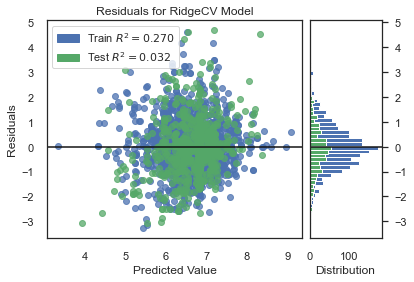

<AxesSubplot:title={'center':'Residuals for RidgeCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [123]:
ridge_cv_5_fold = RidgeCV(cv=5)
visualizer = ResidualsPlot(ridge_cv_5_fold, hist=True)
visualizer.fit(X_train3_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3_scaled, y_test)  # Score on our test data
visualizer.show()                         # Finalize and render the figure

## Ridge Train/Test QQ-Plot

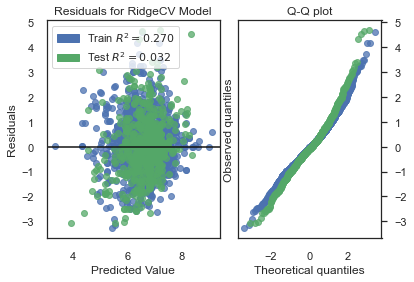

<AxesSubplot:title={'center':'Residuals for RidgeCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [145]:
ridge_cv_5_fold = RidgeCV(cv=5)
visualizer = ResidualsPlot(ridge_cv_5_fold, hist=False, qqplot=True)
visualizer.fit(X_train3_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3_scaled, y_test)  # Score on our test data
visualizer.show()                         # Finalize and render the figure

## Lasso Train/Test Alpha Selection

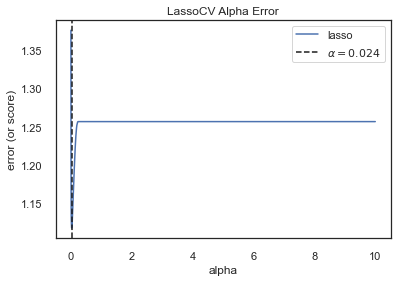

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [80]:
alphas = np.logspace(-10, 1, 400)

model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train3_scaled, y_train)
visualizer.show()

## Lasso Train/Test with Hist

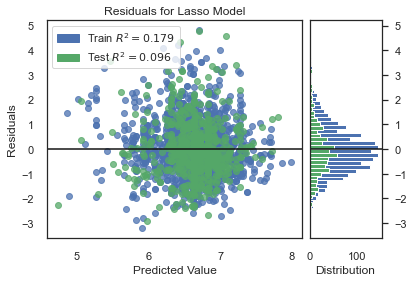

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [93]:
lasso_with_optimized_alpha = Lasso(alpha=0.024)
visualizer = ResidualsPlot(lasso_with_optimized_alpha, hist=True)
visualizer.fit(X_train3_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3_scaled, y_test)  #Score on our test data
visualizer.show()                         # Finalize and render the figure

## Lasso Train/Test with QQ-Plot (with 5-fold CV)

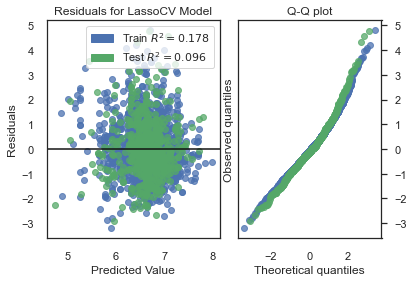

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [102]:
lasso_cv_5_fold = LassoCV(cv=5)
visualizer = ResidualsPlot(lasso_cv_5_fold, hist=False, qqplot=True)
visualizer.fit(X_train3_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3_scaled, y_test)  # Score on our test data
visualizer.show()                         # Finalize and render the figure

## Predicted vs. actual (Lasso)

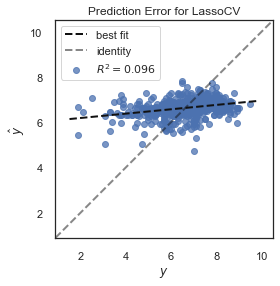

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [132]:
visualizer = PredictionError(model_lasso)

visualizer.fit(X_train3_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Non-yellowbrick visualization of TEST DATA residuals (regplot; Lasso 5-fold CV)

[]

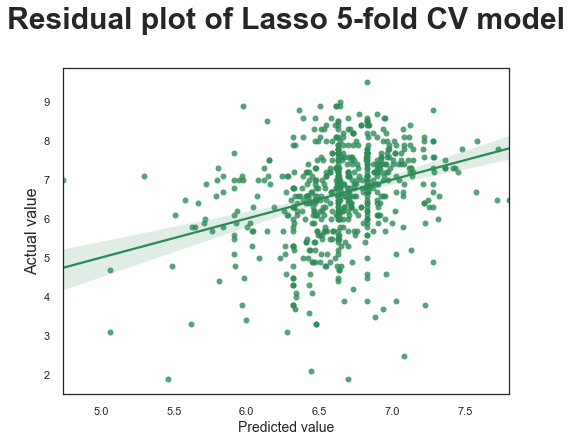

In [147]:
lasso_cv_5_fold = LassoCV(cv=5)
lasso_cv_5_fold.fit(X_train3_scaled, y_train)             # Fit a ridge regression on the training data
test_set_pred_lasso = lasso_cv_5_fold.predict(X_test3_scaled)
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.regplot(x=test_set_pred, y=y_test, color="seagreen")
ax.set_title("Residual plot of Lasso 5-fold CV model", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Predicted value', fontsize=14)
plt.ylabel('Actual value', fontsize=16)
plt.plot()

[]

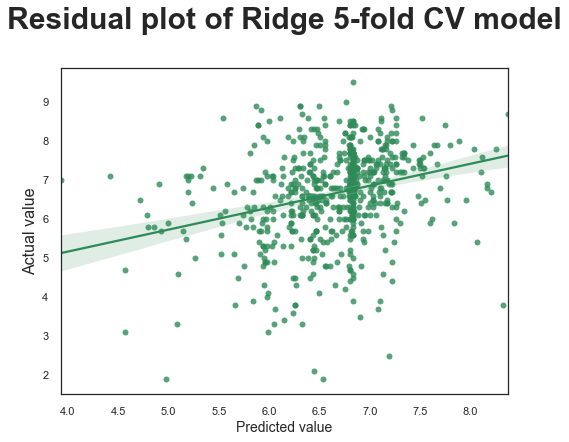

In [148]:
ridge_cv_5_fold = RidgeCV(cv=5)
ridge_cv_5_fold.fit(X_train3_scaled, y_train)             # Fit a ridge regression on the training data
test_set_pred_ridge = ridge_cv_5_fold.predict(X_test3_scaled)
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.regplot(x=test_set_pred_ridge, y=y_test, color="seagreen")
ax.set_title("Residual plot of Ridge 5-fold CV model", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Predicted value', fontsize=14)
plt.ylabel('Actual value', fontsize=16)
plt.plot()

### Outliers at (5, 2), (4, 7), (4.5, 7), etc.

### Seek statistical commonality between outliers as to remove them. What do we tend to predict really badly?

### If we were to use this regularized data, while Lasso and Ridge are very similar, Ridge is better at capturing these outliers, which we actually want, in order to make good interpretations of every movie (capture *every* genre type, *every* movie studio).

### The important thing is that *regularization did not help*, got us in a similar range for Training data, but caused our testing R^2 to be 1/4 what it was. 

## Most influential features (Ridge)

In [135]:
list_of_values = list(zip(X_test3_scaled, ridge_cv_5_fold.coef_))

In [131]:
sorted(((value, index) for index, value in enumerate(list_of_values)), reverse=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Overall, since we underfit we should increase our features.

In [ ]:
test_set_pred = lasso_model.predict(X_test.loc[:,more_features_list])

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

Yay some of the coefficients have been zeroed-out!

#2 Ridge

In [ ]:
lr_model_ridge = Ridge(alpha = 0.01)
lr_model_ridge.fit(X_train.loc[:,more_features_list], y_train)
list(zip(more_features_list, lr_model_ridge.coef_))



Minimizes the coefficients still, but still we have so many features the model becomes hard to read

In [ ]:
test_set_pred = lasso_model.predict(X_test.loc[:,more_features_list])


In [ ]:
df['predicted_imdb'] = lasso_model.prext()

In [ ]:
r2_score(y_test, test_set_pred)


In [ ]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

Tr > Te by .1, which indicates we are *overfitting*. We can use **stronger regularization** to combat this problem, we can try to manually change alpha, or we can find the best value of the regularization strength programmatically.

In [ ]:
list(zip(X_train.columns, lasso_model.coef_))


In [ ]:
mae(y_test, test_set_pred)


In [ ]:
X5

In [ ]:
y = X5['imdbscore']


In [ ]:
len(y)

In [ ]:
lasso_model = Lasso(alpha = 0.01) 
lasso_model.fit(X5.loc[:,more_features_list], y)

X5['pred'] = lasso_model.predict(X5.loc[:,more_features_list])

In [ ]:
X5

In [ ]:
df_final = df.merge(X5, on="mojo_title", how="right")

In [ ]:
df_final.columns

In [ ]:
r2_score(y_test, test_set_pred)


Stepwise regression is a variable selection procedure for independent variables. It consists of a series of steps designed to find the most useful X-variables to include in a regression model.

It's a *forward selection* process since once a variable is selected it cannot be removed from the model.



In [ ]:
X, y = df_new, df_new['imdbscore']

In [ ]:
lasso_model = Lasso(alpha = 0.01) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X.loc[:,more_features_list], y)
list(zip(more_features_list, lasso_model.coef_))

In [ ]:
X5['pred'] = test_

In [ ]:
mangodb_df = df.merge()